In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
DF = pd.read_csv('data/atp_matches_features_balanced.csv')

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple, Dict

from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, brier_score_loss
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

import joblib
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Partindo do DF já carregado no seu ambiente.
assert 'winner' in DF.columns, "DF precisa ter a coluna 'winner'"

# Colunas que não devem entrar no modelo-base (potencial vazamento/memorization)
ID_COLS = ['player1_id', 'player2_id']

# Todas as diferenciais + meta
TARGET = 'winner'
feature_cols = [c for c in DF.columns if c not in ID_COLS + [TARGET]]

# Checagens rápidas
print("Shape:", DF.shape)
print("Target balance:", DF[TARGET].value_counts(normalize=True).round(3).to_dict())
print("Exemplo de features:", feature_cols[:10])

# Drop de linhas com NaN nas features/target (ou troque por imputação se necessário)
data = DF[feature_cols + [TARGET]].dropna().copy()
X = data[feature_cols]
y = data[TARGET].astype(int)


Shape: (95375, 49)
Target balance: {1: 0.5, 0: 0.5}
Exemplo de features: ['best_of', 'draw_size', 'atp_points_differential', 'atp_rank_differential', 'age_differential', 'ht_differential', 'elo_differential', 'elo_surface_differential', 'h2h_differential', 'h2h_surface_differential']


In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [6]:
def build_matchup_groups(df: pd.DataFrame) -> np.ndarray:
    # agrupa por par não ordenado de jogadores (confronto)
    return df[['player1_id','player2_id']].apply(
        lambda r: tuple(sorted((r['player1_id'], r['player2_id']))), axis=1
    ).astype(str).values

groups = build_matchup_groups(DF.loc[data.index, :])
gcv = GroupKFold(n_splits=5)
# use 'gcv.split(X, y, groups=groups)' em vez de 'cv.split(X, y)'


In [7]:
def evaluate_cv(model: Pipeline, X: pd.DataFrame, y: pd.Series, splitter, groups=None, plot_calibration=False, title=""):
    aucs, logs, accs, briers = [], [], [], []
    prob_all, y_all = [], []

    for fold, (tr, te) in enumerate(splitter.split(X, y, groups) if groups is not None else splitter.split(X, y), 1):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]

        model.fit(Xtr, ytr)
        proba = model.predict_proba(Xte)[:,1]
        pred  = (proba >= 0.5).astype(int)

        aucs.append(roc_auc_score(yte, proba))
        logs.append(log_loss(yte, proba, labels=[0,1]))
        accs.append(accuracy_score(yte, pred))
        briers.append(brier_score_loss(yte, proba))

        prob_all.append(proba)
        y_all.append(yte.values)

        print(f"Fold {fold} | AUC={aucs[-1]:.3f}  LogLoss={logs[-1]:.3f}  Acc={accs[-1]:.3f}  Brier={briers[-1]:.3f}")

    prob_all = np.concatenate(prob_all)
    y_all = np.concatenate(y_all)

    print(f"\n[{title}] MÉDIAS  | AUC={np.mean(aucs):.3f}±{np.std(aucs):.3f} | LogLoss={np.mean(logs):.3f} "
          f"| Acc={np.mean(accs):.3f} | Brier={np.mean(briers):.3f}")

    if plot_calibration:
        plt.figure()
        CalibrationDisplay.from_predictions(y_all, prob_all, n_bins=10)
        plt.title(f"Calibration Curve – {title}")
        plt.show()

    return {
        "auc": np.mean(aucs),
        "logloss": np.mean(logs),
        "acc": np.mean(accs),
        "brier": np.mean(briers)
    }


In [8]:
# Baseline (chuta classe majoritária): referência mínima
dummy = DummyClassifier(strategy="most_frequent")

# Transformador numérico (scaling) – útil para modelos lineares
num_transform = ColumnTransformer([
    ("scaler", StandardScaler(with_mean=True, with_std=True), feature_cols)
], remainder="drop")

# Logistic Regression (com classe balanceada)
logreg = Pipeline([
    ("prep", num_transform),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Random Forest
rf = Pipeline([
    ("prep", "passthrough"),  # árvores não precisam de scaling
    ("clf", RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_leaf=10,
        class_weight="balanced_subsample", random_state=42, n_jobs=-1
    ))
])

# HistGradientBoosting (rápido, lida bem com não linearidades)
hgb = Pipeline([
    ("prep", "passthrough"),
    ("clf", HistGradientBoostingClassifier(
        max_depth=None, learning_rate=0.05, max_iter=500,
        l2_regularization=0.0, random_state=42
    ))
])



=== Dummy ===
Fold 1 | AUC=0.500  LogLoss=18.009  Acc=0.500  Brier=0.500
Fold 2 | AUC=0.500  LogLoss=18.011  Acc=0.500  Brier=0.500
Fold 3 | AUC=0.500  LogLoss=18.010  Acc=0.500  Brier=0.500
Fold 4 | AUC=0.500  LogLoss=18.010  Acc=0.500  Brier=0.500
Fold 5 | AUC=0.500  LogLoss=18.010  Acc=0.500  Brier=0.500

[Dummy] MÉDIAS  | AUC=0.500±0.000 | LogLoss=18.010 | Acc=0.500 | Brier=0.500

=== Logistic Regression ===
Fold 1 | AUC=0.737  LogLoss=0.600  Acc=0.671  Brier=0.207
Fold 2 | AUC=0.731  LogLoss=0.605  Acc=0.665  Brier=0.209
Fold 3 | AUC=0.740  LogLoss=0.599  Acc=0.674  Brier=0.207
Fold 4 | AUC=0.729  LogLoss=0.606  Acc=0.663  Brier=0.210
Fold 5 | AUC=0.729  LogLoss=0.606  Acc=0.663  Brier=0.210

[LogReg] MÉDIAS  | AUC=0.733±0.004 | LogLoss=0.603 | Acc=0.667 | Brier=0.209


<Figure size 640x480 with 0 Axes>

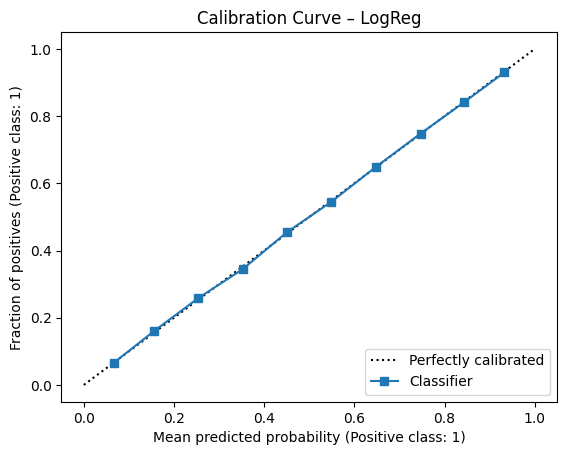


=== Random Forest ===
Fold 1 | AUC=0.732  LogLoss=0.605  Acc=0.667  Brier=0.209
Fold 2 | AUC=0.726  LogLoss=0.608  Acc=0.662  Brier=0.211
Fold 3 | AUC=0.735  LogLoss=0.603  Acc=0.673  Brier=0.208
Fold 4 | AUC=0.725  LogLoss=0.609  Acc=0.658  Brier=0.211
Fold 5 | AUC=0.726  LogLoss=0.608  Acc=0.664  Brier=0.211

[RF] MÉDIAS  | AUC=0.729±0.004 | LogLoss=0.606 | Acc=0.665 | Brier=0.210


<Figure size 640x480 with 0 Axes>

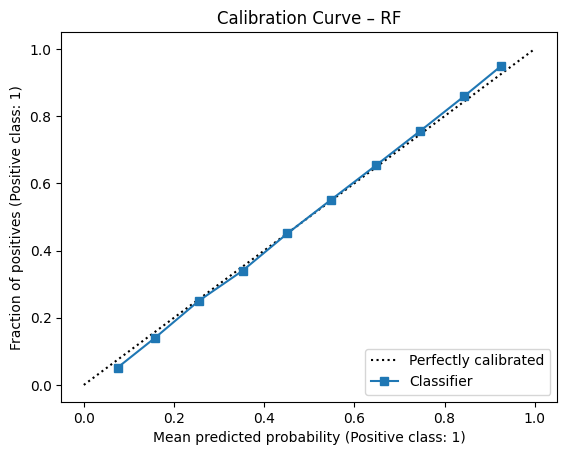


=== HistGradientBoosting ===
Fold 1 | AUC=0.736  LogLoss=0.601  Acc=0.671  Brier=0.208
Fold 2 | AUC=0.729  LogLoss=0.605  Acc=0.662  Brier=0.210
Fold 3 | AUC=0.738  LogLoss=0.600  Acc=0.673  Brier=0.207
Fold 4 | AUC=0.727  LogLoss=0.607  Acc=0.660  Brier=0.210
Fold 5 | AUC=0.729  LogLoss=0.606  Acc=0.663  Brier=0.210

[HGB] MÉDIAS  | AUC=0.732±0.004 | LogLoss=0.604 | Acc=0.666 | Brier=0.209


<Figure size 640x480 with 0 Axes>

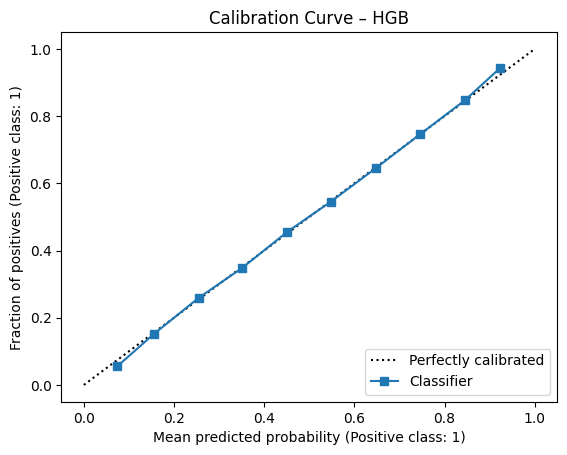

In [9]:
print("\n=== Dummy ===")
_ = evaluate_cv(dummy, X, y, cv, title="Dummy", plot_calibration=False)

print("\n=== Logistic Regression ===")
res_log = evaluate_cv(logreg, X, y, cv, title="LogReg", plot_calibration=True)

print("\n=== Random Forest ===")
res_rf = evaluate_cv(rf, X, y, cv, title="RF", plot_calibration=True)

print("\n=== HistGradientBoosting ===")
res_hgb = evaluate_cv(hgb, X, y, cv, title="HGB", plot_calibration=True)


In [10]:
param_dist_hgb = {
    "clf__learning_rate":  np.logspace(-2.5, -0.5, 20),
    "clf__max_iter":       [200, 400, 600, 800],
    "clf__max_depth":      [None, 3, 5, 7, 9],
    "clf__l2_regularization": np.logspace(-4, 1, 10),
    "clf__min_samples_leaf": [10, 20, 50, 100]
}

hgb_base = Pipeline([("prep","passthrough"), ("clf", HistGradientBoostingClassifier(random_state=42))])

search = RandomizedSearchCV(
    estimator=hgb_base,
    param_distributions=param_dist_hgb,
    n_iter=60,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)
print("Melhor AUC (CV):", search.best_score_)
print("Melhores params:", search.best_params_)
best_hgb = search.best_estimator_


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Melhor AUC (CV): 0.7322618582210495
Melhores params: {'clf__min_samples_leaf': 50, 'clf__max_iter': 600, 'clf__max_depth': 7, 'clf__learning_rate': np.float64(0.017252105499420408), 'clf__l2_regularization': np.float64(2.782559402207126)}


In [11]:
import optuna
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# Usa X, y e gcv já definidos acima
def objective(trial: optuna.trial.Trial) -> float:
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),
        "max_iter": trial.suggest_int("max_iter", 200, 1000, step=100),
        "max_depth": trial.suggest_categorical("max_depth", [None, 3, 5, 7, 9]),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-5, 10.0, log=True),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 200, step=10),
        "random_state": 42
    }

    clf = HistGradientBoostingClassifier(**params)

    aucs = []
    for tr, te in gcv.split(X, y, groups=groups):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        clf.fit(Xtr, ytr)
        proba = clf.predict_proba(Xte)[:, 1]
        aucs.append(roc_auc_score(yte, proba))

    return float(np.mean(aucs))

study = optuna.create_study(
    direction="maximize",
    study_name="hgb_optuna_auc_nopipe",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10)
)

# Ajuste n_trials conforme o tempo disponível
study.optimize(objective, n_trials=100, show_progress_bar=False, n_jobs=12)

print("Best AUC (CV):", study.best_value)
print("Best params:", study.best_params)

# Treina o melhor modelo em todo o dataset e registra como best_model para reuso
best_params = dict(study.best_params)
best_params["random_state"] = 42
best_model = HistGradientBoostingClassifier(**best_params)
best_model.fit(X, y)

[I 2025-11-05 15:35:05,267] A new study created in memory with name: hgb_optuna_auc_nopipe
[I 2025-11-05 15:35:46,433] Trial 1 finished with value: 0.731830508992012 and parameters: {'learning_rate': 0.04135711035990486, 'max_iter': 700, 'max_depth': 3, 'l2_regularization': 0.001259463761202775, 'min_samples_leaf': 100}. Best is trial 1 with value: 0.731830508992012.
[I 2025-11-05 15:35:58,064] Trial 10 finished with value: 0.7318966659527105 and parameters: {'learning_rate': 0.03160616747847627, 'max_iter': 400, 'max_depth': 3, 'l2_regularization': 0.5991532161977277, 'min_samples_leaf': 90}. Best is trial 10 with value: 0.7318966659527105.
[I 2025-11-05 15:36:10,486] Trial 8 finished with value: 0.7317039085136272 and parameters: {'learning_rate': 0.016921677225633463, 'max_iter': 400, 'max_depth': 3, 'l2_regularization': 0.0008194796056765136, 'min_samples_leaf': 20}. Best is trial 10 with value: 0.7318966659527105.
[I 2025-11-05 15:36:24,177] Trial 14 finished with value: 0.7313390

Best AUC (CV): 0.7321367366103284
Best params: {'learning_rate': 0.01323574879863744, 'max_iter': 400, 'max_depth': 9, 'l2_regularization': 4.327245913532525, 'min_samples_leaf': 60}


,loss,'log_loss'
,learning_rate,0.01323574879863744
,max_iter,400
,max_leaf_nodes,31
,max_depth,9
,min_samples_leaf,60
,l2_regularization,4.327245913532525
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
,monotonic_cst,None


In [12]:
from sklearn.inspection import permutation_importance

# Permutation Importance
r = permutation_importance(best_model, X, y, scoring="roc_auc", n_repeats=15, random_state=42, n_jobs=-1)
perm_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)
print(perm_imp.head(20))

# Plot: top 10
top10 = perm_imp.head(10).iloc[::-1]
plt.figure()
plt.barh(top10["feature"], top10["importance_mean"])
plt.title("Permutation Importance (top 10)")
plt.xlabel("Aumento de erro em AUC (médio)")
plt.tight_layout()
plt.show()

# Partial Dependence das 3 mais importantes (se forem contínuas)
top3 = perm_imp["feature"].head(3).tolist()
for feat in top3:
    plt.figure()
    try:
        PartialDependenceDisplay.from_estimator(best_model, X, [feat], kind="average")
        plt.title(f"Partial Dependence – {feat}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Não foi possível PDP de {feat}: {e}")


KeyboardInterrupt: 

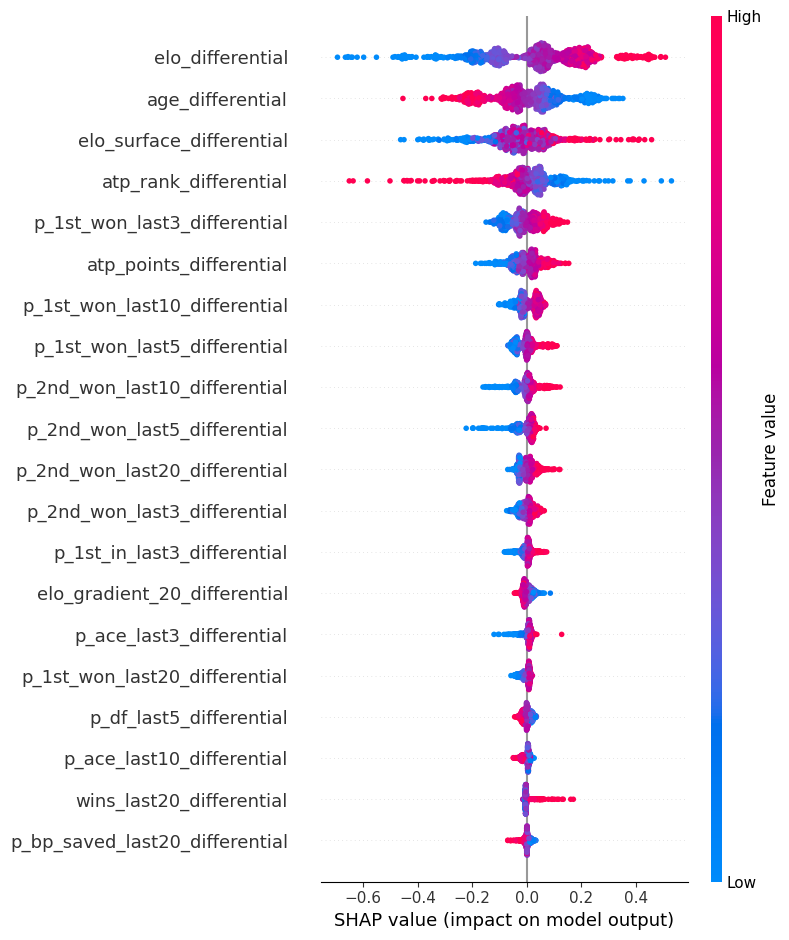

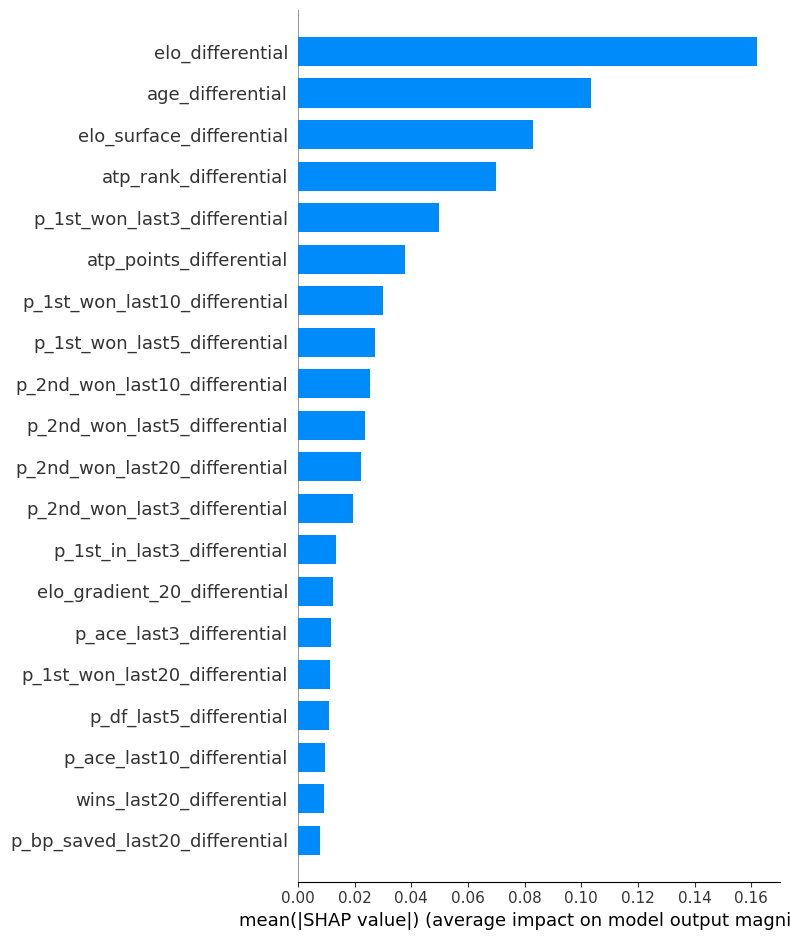

In [14]:
import shap

explainer = shap.TreeExplainer(best_model)

X_subset = X.iloc[:1000]
shap_values = explainer.shap_values(X_subset)

shap.summary_plot(shap_values, X_subset, feature_names=feature_cols)

shap.summary_plot(shap_values, X_subset, feature_names=feature_cols, plot_type="bar")

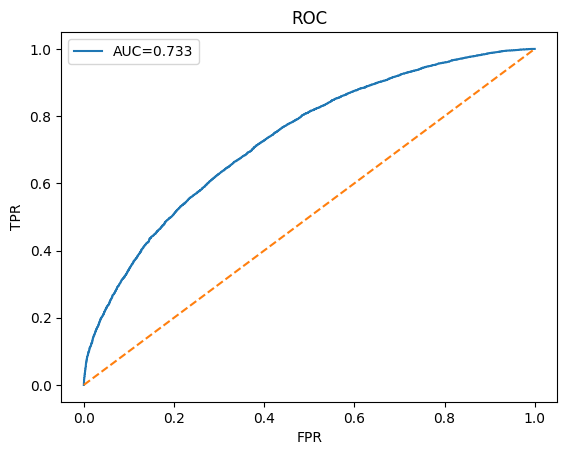

<Figure size 640x480 with 0 Axes>

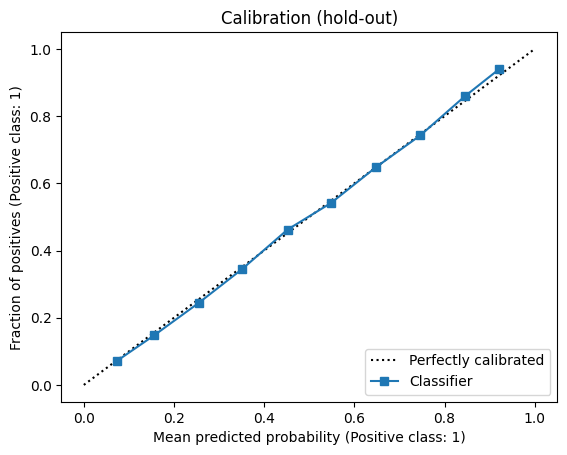

In [15]:
# split final para ilustração de curvas
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)
best_model.fit(X_tr, y_tr)
proba = best_model.predict_proba(X_te)[:,1]

# ROC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_te, proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_te, proba):.3f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# Calibration
plt.figure()
CalibrationDisplay.from_predictions(y_te, proba, n_bins=10)
plt.title("Calibration (hold-out)")
plt.show()


Threshold: 0.500
Precision: 0.665 | Recall: 0.661 | F1: 0.663


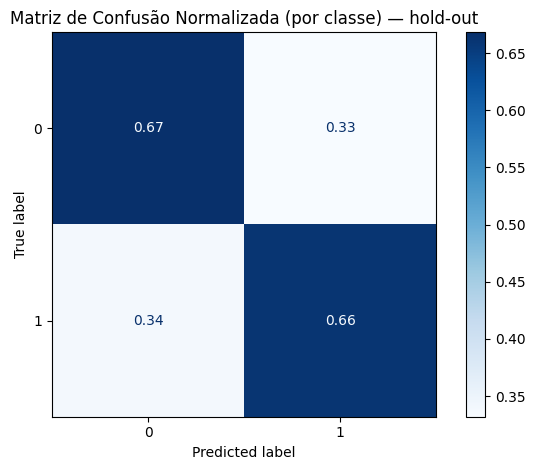

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=7
)
best_model.fit(X_tr, y_tr)

proba = best_model.predict_proba(X_te)[:, 1]
threshold = 0.5
y_pred = (proba >= threshold).astype(int)

cm_norm = confusion_matrix(y_te, y_pred, labels=[0,1], normalize="true")
prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary")

print(f"Threshold: {threshold:.3f}")
print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[0,1])
disp.plot(ax=ax, values_format=".2f", cmap="Blues", colorbar=True)
ax.set_title("Matriz de Confusão Normalizada (por classe) — hold-out")
plt.tight_layout()
plt.show()


In [19]:
# from sklearn.base import BaseEstimator, TransformerMixin

# class TargetEncoder(BaseEstimator, TransformerMixin):
#     """Target encoding simples para IDs com smoothing."""
#     def __init__(self, cols: List[str], min_samples: int = 20, smoothing: float = 10.0):
#         self.cols = cols
#         self.min_samples = min_samples
#         self.smoothing = smoothing
#         self.global_mean_ = None
#         self.maps_ = {}

#     def fit(self, X, y):
#         df = X.copy()
#         df["_y"] = y.values
#         self.global_mean_ = df["_y"].mean()
#         self.maps_ = {}
#         for c in self.cols:
#             stats = df.groupby(c)["_y"].agg(["mean","count"])
#             smooth = (stats["count"] * stats["mean"] + self.smoothing * self.global_mean_) / (stats["count"] + self.smoothing)
#             self.maps_[c] = smooth.to_dict()
#         return self

#     def transform(self, X):
#         X = X.copy()
#         for c in self.cols:
#             X[f"{c}_te"] = X[c].map(self.maps_[c]).fillna(self.global_mean_)
#         return X.drop(columns=self.cols)

# # Exemplo de uso em nested CV:
# all_cols = ID_COLS + feature_cols
# X_all = DF[all_cols].dropna()
# y_all = DF.loc[X_all.index, TARGET].astype(int)

# outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# pipe_te_hgb = Pipeline([
#     ("te", TargetEncoder(cols=ID_COLS, min_samples=20, smoothing=20.0)),
#     ("clf", HistGradientBoostingClassifier(random_state=42))
# ])

# param_dist_te = {
#     "clf__learning_rate":  np.logspace(-2.5, -0.5, 12),
#     "clf__max_iter":       [300, 600, 900],
#     "clf__max_depth":      [None, 3, 5, 7],
#     "clf__l2_regularization": np.logspace(-4, 1, 8),
#     "clf__min_samples_leaf": [10, 20, 50]
# }

# outer_scores = []
# for tr_idx, te_idx in outer.split(X_all, y_all):
#     Xtr, Xte = X_all.iloc[tr_idx], X_all.iloc[te_idx]
#     ytr, yte = y_all.iloc[tr_idx], y_all.iloc[te_idx]

#     search_te = RandomizedSearchCV(
#         pipe_te_hgb, param_dist_te, n_iter=40, scoring="roc_auc",
#         cv=inner, random_state=42, n_jobs=-1
#     )
#     search_te.fit(Xtr, ytr)
#     proba = search_te.best_estimator_.predict_proba(Xte)[:,1]
#     outer_scores.append(roc_auc_score(yte, proba))
#     print(f"Outer AUC: {outer_scores[-1]:.3f} | best params: {search_te.best_params_}")

# print("Nested TE-HGB AUC médio:", np.mean(outer_scores))


In [21]:
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(exist_ok=True)
joblib.dump(best_model, MODELS_DIR / "tennis_winner_model.joblib")


['models\\tennis_winner_model.joblib']

In [22]:
def predict_match(model, row: Dict[str, float]) -> Dict[str, float]:
    """row deve conter o mesmo conjunto de features do treinamento."""
    x = pd.DataFrame([row])[feature_cols]
    proba = model.predict_proba(x)[:,1][0]
    pred = int(proba >= 0.5)
    return {"prob_player1_wins": float(proba), "pred_winner": pred}

# exemplo:
# sample = X.iloc[0].to_dict()
# predict_match(best_model, sample)


In [38]:

sample = X.sample().iloc[0].to_dict()
predict_match(best_model, sample)

{'prob_player1_wins': 0.553995327121796, 'pred_winner': 1}

In [41]:
print(best_model.feature_names_in_)

['best_of' 'draw_size' 'atp_points_differential' 'atp_rank_differential'
 'age_differential' 'ht_differential' 'elo_differential'
 'elo_surface_differential' 'h2h_differential' 'h2h_surface_differential'
 'p_ace_last3_differential' 'p_df_last3_differential'
 'p_1st_in_last3_differential' 'p_1st_won_last3_differential'
 'p_2nd_won_last3_differential' 'p_bp_saved_last3_differential'
 'elo_gradient_3_differential' 'elo_surface_gradient_3_differential'
 'wins_last3_differential' 'p_ace_last5_differential'
 'p_df_last5_differential' 'p_1st_in_last5_differential'
 'p_1st_won_last5_differential' 'p_2nd_won_last5_differential'
 'p_bp_saved_last5_differential' 'elo_gradient_5_differential'
 'elo_surface_gradient_5_differential' 'wins_last5_differential'
 'p_ace_last10_differential' 'p_df_last10_differential'
 'p_1st_in_last10_differential' 'p_1st_won_last10_differential'
 'p_2nd_won_last10_differential' 'p_bp_saved_last10_differential'
 'elo_gradient_10_differential' 'elo_surface_gradient_10_di